<div align = 'right' ><h5>Name : Shubham Narandekar</h5></div>
<div align = 'right' ><h5>Student Id : 20200132</h5></div>

# Convolutional Neural Network for Pneumonia detection using chest X-Ray images

In [9]:
import os
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sample_data import Models
from sklearn import metrics
from sklearn.model_selection import train_test_split

Checking if the GPU is available.

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Data Preprocessing

Resizing the images from (256,256) to (224,224) to avoid GPU memory issues with bigger images.

In [11]:
#Transforms
transformer2=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor() #0-255 to 0-1, numpy to tensors
])


Classes =  ['NORMAL', 'PNEUMONIA']
Train =  5216
Validation =  16


<BarContainer object of 2 artists>

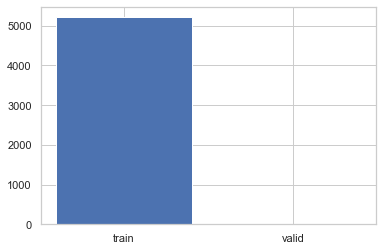

In [12]:
#Path for training and testing directory
train_path='/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
valid_path='/content/drive/MyDrive/Colab Notebooks/chest_xray/val'

#Dataloader
btrain = torchvision.datasets.ImageFolder(train_path,transform=transformer2)
bvalid = torchvision.datasets.ImageFolder(valid_path,transform=transformer2)

print('Classes = ', btrain.classes)
print('Train = ', len(btrain))
print('Validation = ', len(bvalid))

sns.set_theme(style="whitegrid")
plt.bar(['train','valid'], [len(btrain),len(bvalid)])

As we can see from the above plot that there are just 16 images for our validation set. This small validation set won't be able to evaluate the model's performance in a robust manner. Re-sampling of training and validation test in needed in further pre-processing.

In [ ]:
#To count the number of images per class.
def class_count(dataset):
    classes = []
    class_names = dataset.classes
    for _,label in dataset:
        if label == 0:
            classes.append(class_names[label])
            
        elif label == 1:
            classes.append(class_names[label])
            
    return classes
trainset_class_count = class_count(btrain)

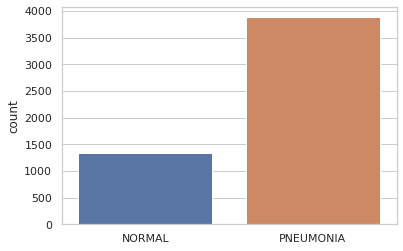

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=trainset_class_count)

From the above plot we can see that there is no balance in the images from both the class. If such data is used for training then the model might favour the majority class and can lead to poor predictions for minority class. I am going to handle this issue of class imbalance further in the notebook.

Now that we have only 16 images in our validation set, I am going to combine the training and validation set and again split them with appropriate spliting criteria to have enough images in the validation set.

In [ ]:
#Combining train and valid dataset into a single dataframe
def combine(train, valid):
    comb = pd.DataFrame({
      'source': np.full(len(train), 't'),
      'index' : np.arange(len(train))
      })

    for i in range(len(valid)):
        row = pd.Series({
        'source': 'v',
        'index' : i
        })
        row.name = len(train) + i + 1
        comb = comb.append(row)
    return comb

In [ ]:
comb = combine(btrain, bvalid)
train_df, val_df = train_test_split(comb, test_size=0.1, random_state=0)
len(train_df), len(val_df)

(4717, 525)

In [ ]:
#For converting dataframe back to dataset
class FrametoDataset(Dataset):
    """Wrap a dataloader to move data to a device"""
    def __init__(self, name, df, train, valid):
        self.name = name
        self.df = df
        self.train = train
        self.valid = valid
        
    def __getitem__(self, index):
        row = self.df.iloc[index]
        if row['source'] == 't':        
            return (self.train[row['index']][0], self.train[row['index']][1])
        else:
            return (self.valid[row['index']][0], self.valid[row['index']][1])

    def __len__(self):
        return len(self.df)

Train =  4717
Validation =  525


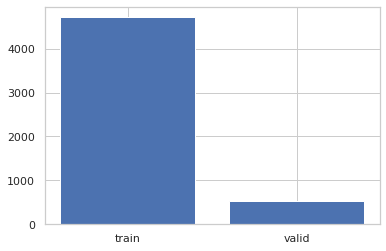

In [ ]:
bvalid = FrametoDataset('valid', val_df, btrain, bvalid)
btrain = FrametoDataset('train', train_df, btrain, bvalid)

plt.bar(['train','valid'], [len(btrain),len(bvalid)])
print('Train = ', len(btrain))
print('Validation = ', len(bvalid))

After combining now we can see that there are enough images in the validation set.

I tried using 64 and 128 as the batch size but as it depends on the GPU's capacity, I got cuda out of memory error. So I decided to use smaller batch size because they usually have faster convergence to good results. Batch size 8 worked best for my training data and it also lowered the generalization error.

In [ ]:
Models.seed()
btrain_loader=DataLoader(
    btrain, batch_size=8, shuffle=True
)
bvalid_loader=DataLoader(
    bvalid, batch_size=4, shuffle=True
)

In [ ]:
#calculating the size of training and validation images
train_count=len(btrain)
val_count =len(bvalid)
print(train_count,val_count)

4717 525


Initially I have started with training my proposed model using the baseline approach. I will also follow the baseline approach for the pre-trained VGG16 model by tuning it with just a single fully connected layer. After these models are trained I am going to save the best model and evaluate their performance on unseen test data. Depending on the results I will further decide the steps that I could take to improve both the models.

### Proposed Model (Basic)

In [ ]:
model = Models.cnn()
model.to(device)

cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (fc): Linear(in_features=401408, out_features=2, bias=True)
)

In the above architecture non linear activation function for the final layer is not specified because I am using CrossEntropyLoss function which internally combines LogSoftmax and NLLLoss function.

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10
best_accuracy= 0.0
v1_train_accuracy = 0.0
v1_train_auc = 0.0
best_loss = 1.0
v1_tloss = []
v1_vloss = []
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    t_roc, train_loss, train_accuracy = Models.fit(model, device, btrain_loader, train_count, optimizer, loss_function)
    v1_tloss.append(train_loss)
        
    # Evaluation on validation dataset
    v_roc, val_loss, test_accuracy = Models.evaluate(model, device, bvalid_loader, val_count, loss_function)
    v1_vloss.append(val_loss)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train AUC: '+str(t_roc)+' Validation loss: '+str(val_loss)+' Validation AUC: '+str(v_roc))
    
    #Save the best model
    if val_loss<=best_loss:
        torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/proposed_v1_checkpoint.model')
        best_loss=val_loss
        v1_train_auc = t_roc
       


Epoch: 0 Train Loss: tensor(0.2504) Train AUC: 0.856942940769847 Validation loss: tensor(0.1368) Validation AUC: 0.8853383458646615
Epoch: 1 Train Loss: tensor(0.1048) Train AUC: 0.947855028718034 Validation loss: tensor(0.1180) Validation AUC: 0.922514619883041
Epoch: 2 Train Loss: tensor(0.0871) Train AUC: 0.9579774376070855 Validation loss: tensor(0.1227) Validation AUC: 0.9630325814536341
Epoch: 3 Train Loss: tensor(0.0626) Train AUC: 0.9672424586710441 Validation loss: tensor(0.0934) Validation AUC: 0.9477861319966584
Epoch: 4 Train Loss: tensor(0.0568) Train AUC: 0.9715268167165753 Validation loss: tensor(0.1010) Validation AUC: 0.9371345029239767
Epoch: 5 Train Loss: tensor(0.0551) Train AUC: 0.9748108889661647 Validation loss: tensor(0.1142) Validation AUC: 0.9369256474519632
Epoch: 6 Train Loss: tensor(0.0264) Train AUC: 0.9891994710193999 Validation loss: tensor(0.1006) Validation AUC: 0.9438178780284044
Epoch: 7 Train Loss: tensor(0.0251) Train AUC: 0.9878432308363025 Valida

I am using the validation loss as the criteria to save the model. The epoch with lowest validation loss will be saved.

In [ ]:
print(v1_train_auc)

0.9672424586710441


The AUC score displayed above is the training AUC score for that epoch where the best model was saved.

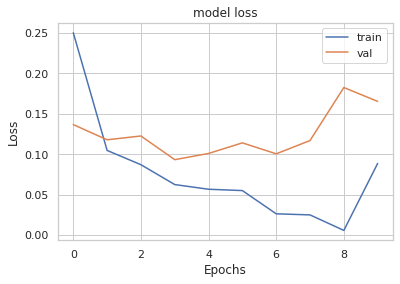

In [ ]:
plt.plot(v1_tloss)
plt.plot(v1_vloss)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the above graph for loss we can clearly see that the validation loss is going much high than our training loss. This is a case of overfitting. My model is actually performing well on the training data but it failing to generalize well on the validation data.

### VGG_16 Model (Basic)

In [ ]:
model2 = torchvision.models.vgg16(pretrained=True)
# freeze the model layer
for param in model2.parameters():
    param.requires_grad = False

# add Linear classifier layer
in_features = model2.classifier[0].in_features
classifier = nn.Sequential(
    nn.Linear(in_features, 2)
)
model2.classifier = classifier
model2.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

As we can see, I have just used a single fully connected layer to fine tune the model. Depending on its results I will further improve the model. Also, I have not specified the non linear activation function because I am using CrossEntropyLoss which internally combines the LogSoftmax and NLLLoss function.

In [ ]:
optimizer=Adam(model2.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10
best_accuracy=0.0
vgg_train_accuracy=0.0
vgg_train_auc=0.0
best_loss = 1.0
vgg_tloss = []
vgg_vloss = []
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    t_roc, train_loss, train_accuracy = Models.fit(model2, device, btrain_loader, train_count, optimizer, loss_function)
    vgg_tloss.append(train_loss)
        
    # Evaluation on validation dataset
    v_roc, val_loss, test_accuracy = Models.evaluate(model2, device, bvalid_loader, val_count, loss_function)
    vgg_vloss.append(val_loss)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train AUC: '+str(t_roc)+' Validation loss: '+str(val_loss)+' Validation AUC: '+str(v_roc))
    
    #Save the best model
    if val_loss<=best_loss:
        torch.save(model2.state_dict(),'/content/drive/MyDrive/Colab Notebooks/vgg16_v1_checkpoint.model')
        best_loss=val_loss
        vgg_train_auc = t_roc

Epoch: 0 Train Loss: tensor(0.1408) Train AUC: 0.9493541668719798 Validation loss: tensor(0.0711) Validation AUC: 0.9711779448621554
Epoch: 1 Train Loss: tensor(0.0603) Train AUC: 0.983790114088426 Validation loss: tensor(0.1275) Validation AUC: 0.9797410192147034
Epoch: 2 Train Loss: tensor(0.0394) Train AUC: 0.9865753339800112 Validation loss: tensor(0.0813) Validation AUC: 0.9830827067669172
Epoch: 3 Train Loss: tensor(0.0290) Train AUC: 0.9916988949692874 Validation loss: tensor(0.0729) Validation AUC: 0.9843358395989974
Epoch: 4 Train Loss: tensor(0.0154) Train AUC: 0.9947517259212225 Validation loss: tensor(0.1077) Validation AUC: 0.9860066833751044
Epoch: 5 Train Loss: tensor(0.0197) Train AUC: 0.9936449119171277 Validation loss: tensor(0.1101) Validation AUC: 0.9803675856307436
Epoch: 6 Train Loss: tensor(0.0016) Train AUC: 0.9994465929979524 Validation loss: tensor(0.0917) Validation AUC: 0.9791144527986634
Epoch: 7 Train Loss: tensor(0.0406) Train AUC: 0.9911454879672401 Vali

In [ ]:
print(vgg_train_auc)

0.9493541668719798


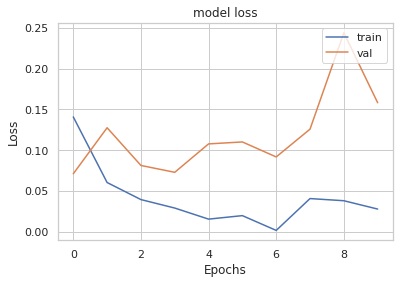

In [ ]:
plt.plot(vgg_tloss)
plt.plot(vgg_vloss)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the above graph for loss we can clearly see that the validation loss is going much high than our training loss. This is a case of overfitting. My model is actually performing well on the training data but it failing to generalize well on the validation data. So even the pre-trained VGG16 model is overfitting for my dataset.

###### There are mainly two techniques that we can use to resolve the issue of overfitting:
 - Data Augmentation: This technique is usually used to increase the number of images in your training dataset. We can flip the images horizontally and can also rotate the images to create more images.
 - Regularization: Dropout is a good regularization method that I am going to use to improve my models. It helps to reduce overfitting by randomly dropping neurons from the neural networks during each epoch. Since each time we are dropping neurons, the model does not favour particular neurons every time, thus reducing overfitting.

## Data Augmentation

In [ ]:
def datatransformation(flag = None):
    
    if flag=='TRAIN':

        transformed = transforms.Compose([
            
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif flag=='TEST' or flag=='VAL':

        transformed = transforms.Compose([

                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return transformed

train = torchvision.datasets.ImageFolder(train_path,transform=datatransformation('TRAIN'))
valid = torchvision.datasets.ImageFolder(valid_path,transform=datatransformation('VAL'))

In [ ]:
#Combinning train and valid datasets into a dataframe and then splitting them.
comb2= combine(train, valid)
train_df2, val_df2 = train_test_split(comb2, test_size=0.1, random_state=0)
len(train_df2), len(val_df2)

(4717, 525)

Train =  4717
Validation =  525


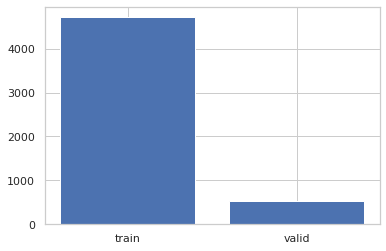

In [ ]:
#Converting back to dataset from dataframe.
valid = FrametoDataset('valid', val_df2, train, valid)
train = FrametoDataset('train', train_df2, train, valid)

plt.bar(['train','valid'], [len(train),len(valid)])
print('Train = ', len(train))
print('Validation = ', len(valid))

In [ ]:
#Data loader after augmentaion
Models.seed()
train_loader=DataLoader(
    train, batch_size=8, shuffle=True
)
valid_loader=DataLoader(
    valid, batch_size=4, shuffle=True
)

In [ ]:
#calculating the size of training and validation images
train_count=len(train)
val_count =len(valid)
print(train_count,val_count)

4717 525


After training the proposed model and VGG16 model using the baseline approach, I have analysed the loss curves for both the models and got to know that both the model are overfitting. So to improve the model I have used regularization techniques like dropouts in my proposed model as well as VGG16 model and have also applied data augmentation to the existing training data. Now lets train the imporved model and analyse their loss curves.

### Proposed Model (With Improvemnets and changes)

In [ ]:
model3 = Models.cnn2()
model3.to(device)

cnn2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1

As you can see that the proposed model was improved by adding dropouts before each fully connected layers. I have also added another convolutional layer and batch normalization for stabilizing the learning process.

Earlier we saw the plot for class imbalance. I din't resolve the issue of class imbalance in the baseline approach but now I will use some techniques in the impoved approach to resolve it. There are two things we can do for class imbalance issue: WeightedRandomSampler or specifying weights in the loss function. I got better results by using the second method so I am specifying weights in the loss function and assigning higher weight to the minority class 'Normal' and lower weight to the majority class 'Pneumonia'. By doing this we can give higher priority to the minority class while computing the loss for that class.


In [ ]:
optimizer=Adam(model3.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.80,0.20]).cuda())

In [ ]:
num_epochs = 10
best_accuracy=0.0
v2_train_accuracy=0.0
v2_train_auc=0.0
best_loss = 1.0
v2_tloss = []
v2_vloss = []
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    t_roc, train_loss, train_accuracy = Models.fit(model3, device, train_loader, train_count, optimizer, loss_function)
    v2_tloss.append(train_loss)
        
    # Evaluation on validation dataset
    v_roc, val_loss, test_accuracy = Models.evaluate(model3, device, valid_loader, val_count, loss_function)
    v2_vloss.append(val_loss)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train AUC: '+str(t_roc)+' Validation loss: '+str(val_loss)+' Validation AUC: '+str(v_roc))
    
    #Save the best model
    if val_loss<=best_loss:
        torch.save(model3.state_dict(),'/content/drive/MyDrive/Colab Notebooks/proposed_v2_checkpoint.model')
        best_loss=val_loss
        v2_train_auc = t_roc
    
       


Epoch: 0 Train Loss: tensor(0.7593) Train AUC: 0.871815006023302 Validation loss: tensor(0.1634) Validation AUC: 0.9298245614035089
Epoch: 1 Train Loss: tensor(0.1899) Train AUC: 0.9244171804188952 Validation loss: tensor(0.1446) Validation AUC: 0.9538429406850459
Epoch: 2 Train Loss: tensor(0.1921) Train AUC: 0.926700966872543 Validation loss: tensor(0.3235) Validation AUC: 0.8865914786967418
Epoch: 3 Train Loss: tensor(0.1946) Train AUC: 0.9240768298331544 Validation loss: tensor(0.1430) Validation AUC: 0.9450710108604845
Epoch: 4 Train Loss: tensor(0.1629) Train AUC: 0.9434148673019878 Validation loss: tensor(0.1725) Validation AUC: 0.9411027568922306
Epoch: 5 Train Loss: tensor(0.1520) Train AUC: 0.9446126057128216 Validation loss: tensor(0.1777) Validation AUC: 0.9143692564745195
Epoch: 6 Train Loss: tensor(0.1581) Train AUC: 0.9448620318918236 Validation loss: tensor(0.1178) Validation AUC: 0.9590643274853802
Epoch: 7 Train Loss: tensor(0.1528) Train AUC: 0.9475225386939078 Valid

In [ ]:
print(v2_train_auc)

0.9489359146009815


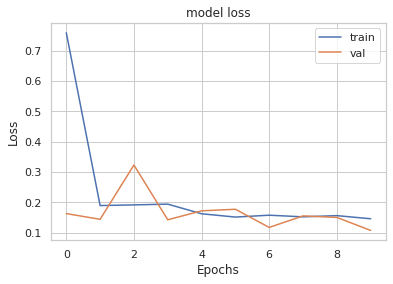

In [ ]:
plt.plot(v2_tloss)
plt.plot(v2_vloss)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the above graph we can cearly see that now the proposed model is performing better after improvement because the validation loss curve is almost similar to the training loss curve. The validation loss is fluctuating a little because there is noise in the dataset.

### Transfer Learning with VGG_16 model (With Improvements)

In [ ]:
model4 = torchvision.models.vgg16(pretrained=True)

for param in model4.parameters():
    param.requires_grad = False


in_features = model4.classifier[0].in_features
classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)
model4.classifier = classifier
model4.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

To improve VGG16 model, I have added another linear layer along with dropouts before each linear layers. I have also tried adding batch normalization because it was not introduced when VGG16 was originally build.

Have used same technique as above to resolve the class imbalance issue.

In [ ]:
optimizer=Adam(model4.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.80,0.20]).cuda())

In [ ]:
num_epochs = 10
best_accuracy=0.0
vggv2_train_accuracy=0.0
vggv2_train_auc=0.0
best_loss = 1.0
vggv2_tloss = []
vggv2_vloss = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    t_roc, train_loss, train_accuracy = Models.fit(model4, device, train_loader, train_count, optimizer, loss_function)
    vggv2_tloss.append(train_loss)
        
    # Evaluation on validation dataset
    v_roc, val_loss, test_accuracy = Models.evaluate(model4, device, valid_loader, val_count, loss_function)
    vggv2_vloss.append(val_loss)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train AUC: '+str(t_roc)+' Validation loss: '+str(val_loss)+' Validation AUC: '+str(v_roc))
    
    #Save the best model
    if val_loss<=best_loss:
        torch.save(model4.state_dict(),'/content/drive/MyDrive/Colab Notebooks/vgg16_v2_checkpoint.model')
        best_loss=val_loss
        vggv2_train_auc = t_roc

Epoch: 0 Train Loss: tensor(0.2687) Train AUC: 0.894065557553155 Validation loss: tensor(0.1079) Validation AUC: 0.9607351712614871
Epoch: 1 Train Loss: tensor(0.1952) Train AUC: 0.9237936149713899 Validation loss: tensor(0.0907) Validation AUC: 0.9690893901420218
Epoch: 2 Train Loss: tensor(0.1838) Train AUC: 0.9279350750460722 Validation loss: tensor(0.1189) Validation AUC: 0.9605263157894737
Epoch: 3 Train Loss: tensor(0.1793) Train AUC: 0.931097015286094 Validation loss: tensor(0.0864) Validation AUC: 0.9784878863826232
Epoch: 4 Train Loss: tensor(0.1830) Train AUC: 0.9294186093986038 Validation loss: tensor(0.0892) Validation AUC: 0.9670008354218881
Epoch: 5 Train Loss: tensor(0.1818) Train AUC: 0.930455264957241 Validation loss: tensor(0.1080) Validation AUC: 0.95843776106934
Epoch: 6 Train Loss: tensor(0.1763) Train AUC: 0.9381302234605149 Validation loss: tensor(0.0790) Validation AUC: 0.9705513784461153
Epoch: 7 Train Loss: tensor(0.1558) Train AUC: 0.9397384709025475 Validati

In [ ]:
print(vggv2_train_auc)

0.9391486941378044


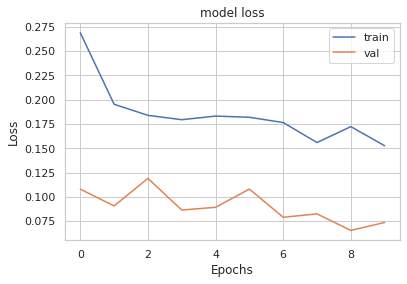

In [ ]:
plt.plot(vggv2_tloss)
plt.plot(vggv2_vloss)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the above graph, we can say that VGG16 was succesfully improved because now our validation loss is less than training which indicates that our model is not overfitting anymore. The reason for the validation loss to be less than the training loss is that I have applied dropouts. When we apply dropouts, we randomly drop some neurons from the fully connected layers so as each time we are dropping neurons it reduces overfitting because the model does not favour particular neurons everytime. So this regularization only takes place during training but during validation or testing all the neurons are used so this is the only reason my validation loss is less than my training loss. The model is performing very good on the unseen testing data.

### Training results

#### Baseline approach results:

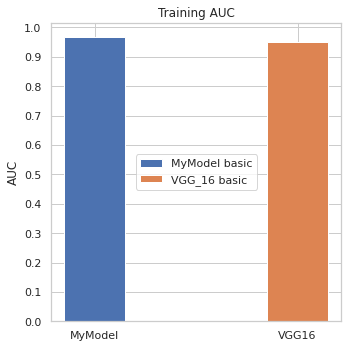

MyModel basic:  0.9672424586710441
VGG_16 basic:  0.9493541668719798


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar('MyModel',v1_train_auc, width=0.3, label='MyModel basic')
ax.bar('VGG16',vgg_train_auc, width=0.3,label='VGG_16 basic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('Training AUC')
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.legend(loc='center')
fig.tight_layout()
plt.show()
print('MyModel basic: ',v1_train_auc)
print('VGG_16 basic: ',vgg_train_auc)

#### Improved approach results

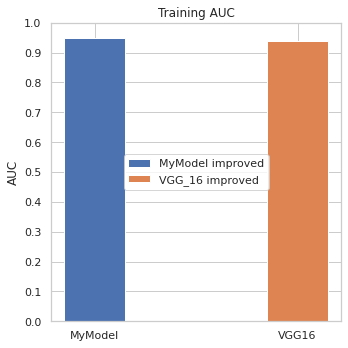

MyModel improved:  0.9489359146009815
VGG_16 improved:  0.9391486941378044


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar('MyModel',v2_train_auc, width=0.3, label='MyModel improved')
ax.bar('VGG16',vggv2_train_auc, width=0.3, label='VGG_16 improved')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('Training AUC')
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.legend(loc='center')
fig.tight_layout()
plt.show()
print('MyModel improved: ',v2_train_auc)
print('VGG_16 improved: ',vggv2_train_auc)

The above training ROC AUC scores for all the models will be used during the evaluation of these models on unseen test data to compare with the testing AUC scores and see how these models are actually performing on unseen data.

### References:
1. https://www.kaggle.com/parthdhameliya77/pneumonia-classfication-tutorial-pytorch
2. https://www.youtube.com/watch?v=9OHlgDjaE2I&list=PL1oOe7xElp02NM7vMylmLuxGmb4-8cIfQ&index=2&t=982s
3. https://www.youtube.com/watch?v=p3CcfIjycBA&list=PL1oOe7xElp02NM7vMylmLuxGmb4-8cIfQ&index=6
4. https://www.youtube.com/watch?v=4JFVhJyTZ44&list=PL1oOe7xElp02NM7vMylmLuxGmb4-8cIfQ&index=5